# Stock Market Analysis using Pyspark

In [1]:
#pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import  substring_index, lit,split
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [3]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("ReadCSVFiles").getOrCreate()

# Set the Hadoop directory path
directory_path_hadoop = "hdfs://localhost:9000//user/root/NSE150_Data"


spark._jsc.hadoopConfiguration().set("fs.defaultFS", "hdfs://localhost:9000")

files_hadoop = spark._jvm.org.apache.hadoop.fs.FileSystem.get(
    spark._jsc.hadoopConfiguration()).listStatus(
        spark._jvm.org.apache.hadoop.fs.Path(directory_path_hadoop))
# Filter CSV files
csv_files = [file.getPath().getName() for file in files_hadoop if file.getPath().getName().endswith('.csv')]
dfs = []

for file in csv_files:
    file_path = f"{directory_path_hadoop}/{file}"
    
    # Read CSV file into a PySpark DataFrame
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    
    # Extract only the part of the file name before the first underscore
    file_name = substring_index(split(lit(file), '_').getItem(0), '__', 1)
    
    # Create a new column 'file_name' with the extracted value
    df = df.withColumn('file_name', file_name)
    
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
result_df = dfs[0]
for df in dfs[1:]:
    # Ensure the DataFrames have the same columns in the same order
    result_df = result_df.select(*df.columns).union(df)

# Display the resulting DataFrame
result_df.show()

23/12/10 22:21:11 WARN Utils: Your hostname, Karthiks-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.230 instead (on interface en0)
23/12/10 22:21:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/10 22:21:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------------------+------+------+------+------+------+---------+
|          timestamp|  open|  high|   low| close|volume|file_name|
+-------------------+------+------+------+------+------+---------+
|2017-01-01 22:45:00| 340.0| 340.0| 340.0| 340.0|  11.0| AARTIIND|
|2017-01-01 22:46:00| 340.0| 340.0| 340.0| 340.0|   0.0| AARTIIND|
|2017-01-01 22:47:00| 340.0| 340.0| 340.0| 340.0|   0.0| AARTIIND|
|2017-01-01 22:48:00| 340.0| 343.7| 340.0| 343.7|   1.0| AARTIIND|
|2017-01-01 22:49:00| 343.7| 343.7| 343.7| 343.7|   1.0| AARTIIND|
|2017-01-01 22:50:00| 341.0| 341.0| 341.0| 341.0| 932.0| AARTIIND|
|2017-01-01 22:51:00| 341.0| 341.0| 339.0| 339.0|   7.0| AARTIIND|
|2017-01-01 22:52:00| 339.0|339.15| 338.0| 338.0|  26.0| AARTIIND|
|2017-01-01 22:53:00| 338.0|338.95| 338.0|338.95|   4.0| AARTIIND|
|2017-01-01 22:54:00| 337.3| 338.5| 337.3| 337.5| 131.0| AARTIIND|
|2017-01-01 22:55:00| 337.5| 338.0| 337.5| 338.0|  68.0| AARTIIND|
|2017-01-01 22:56:00| 338.0| 338.0| 337.5| 337.5|  20.0| AARTI

In [4]:
len(csv_files)

150

# Data Source


The data comprises of Stock values of 149 companies from National Stock Exchange list from 2017 to 2021 captured at every minute.


The dataset is taken from kaggle.
https://www.kaggle.com/datasets/hk7797/stock-market-india

# Data Preprocessing

In [5]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, to_timestamp
# Converting the 'timestamp' column to a timestamp type
result_df = result_df.withColumn("timestamp", to_timestamp(result_df["timestamp"], "yyyy-mm-dd hh:mm:ssXXX"))

# Splitting timestamp into separate columns
final_df = result_df.withColumn("day", dayofmonth("timestamp")) \
    .withColumn("month", month("timestamp")) \
    .withColumn("year", year("timestamp")) \
    .withColumn("hour", hour("timestamp")) \
    .withColumn("minute", minute("timestamp"))
final_df.show(30)

+-------------------+------+------+------+------+------+---------+---+-----+----+----+------+
|          timestamp|  open|  high|   low| close|volume|file_name|day|month|year|hour|minute|
+-------------------+------+------+------+------+------+---------+---+-----+----+----+------+
|2017-01-01 22:45:00| 340.0| 340.0| 340.0| 340.0|  11.0| AARTIIND|  1|    1|2017|  22|    45|
|2017-01-01 22:46:00| 340.0| 340.0| 340.0| 340.0|   0.0| AARTIIND|  1|    1|2017|  22|    46|
|2017-01-01 22:47:00| 340.0| 340.0| 340.0| 340.0|   0.0| AARTIIND|  1|    1|2017|  22|    47|
|2017-01-01 22:48:00| 340.0| 343.7| 340.0| 343.7|   1.0| AARTIIND|  1|    1|2017|  22|    48|
|2017-01-01 22:49:00| 343.7| 343.7| 343.7| 343.7|   1.0| AARTIIND|  1|    1|2017|  22|    49|
|2017-01-01 22:50:00| 341.0| 341.0| 341.0| 341.0| 932.0| AARTIIND|  1|    1|2017|  22|    50|
|2017-01-01 22:51:00| 341.0| 341.0| 339.0| 339.0|   7.0| AARTIIND|  1|    1|2017|  22|    51|
|2017-01-01 22:52:00| 339.0|339.15| 338.0| 338.0|  26.0| AAR

23/12/10 23:03:11 WARN DAGScheduler: Broadcasting large task binary with size 1340.7 KiB


In [6]:
#checking count of null values per column
from pyspark.sql.functions import col, sum
null_counts = final_df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in final_df.columns])

In [7]:
null_counts.show()

23/12/10 23:03:14 WARN DAGScheduler: Broadcasting large task binary with size 1135.6 KiB


+---------+------+------+------+------+------+---------+---+-----+----+----+------+
|timestamp|  open|  high|   low| close|volume|file_name|day|month|year|hour|minute|
+---------+------+------+------+------+------+---------+---+-----+----+----+------+
|        0|105995|105995|105995|105995|105995|        0|  0|    0|   0|   0|     0|
+---------+------+------+------+------+------+---------+---+-----+----+----+------+



Calculated mean values for filling null values

In [8]:
from pyspark.sql.functions import col, mean
columns_to_fill = ["high", "low", "close", "volume","open"]
# Filling missing values with mean values
for column in columns_to_fill:
    mean_value = final_df.agg(mean(col(column))).collect()[0][0]
    final_df = final_df.na.fill(mean_value, [column])
final_df.show()


+-------------------+------+------+------+------+------+---------+---+-----+----+----+------+
|          timestamp|  open|  high|   low| close|volume|file_name|day|month|year|hour|minute|
+-------------------+------+------+------+------+------+---------+---+-----+----+----+------+
|2017-01-01 22:45:00| 340.0| 340.0| 340.0| 340.0|  11.0| AARTIIND|  1|    1|2017|  22|    45|
|2017-01-01 22:46:00| 340.0| 340.0| 340.0| 340.0|   0.0| AARTIIND|  1|    1|2017|  22|    46|
|2017-01-01 22:47:00| 340.0| 340.0| 340.0| 340.0|   0.0| AARTIIND|  1|    1|2017|  22|    47|
|2017-01-01 22:48:00| 340.0| 343.7| 340.0| 343.7|   1.0| AARTIIND|  1|    1|2017|  22|    48|
|2017-01-01 22:49:00| 343.7| 343.7| 343.7| 343.7|   1.0| AARTIIND|  1|    1|2017|  22|    49|
|2017-01-01 22:50:00| 341.0| 341.0| 341.0| 341.0| 932.0| AARTIIND|  1|    1|2017|  22|    50|
|2017-01-01 22:51:00| 341.0| 341.0| 339.0| 339.0|   7.0| AARTIIND|  1|    1|2017|  22|    51|
|2017-01-01 22:52:00| 339.0|339.15| 338.0| 338.0|  26.0| AAR

23/12/10 23:05:28 WARN DAGScheduler: Broadcasting large task binary with size 1821.1 KiB


In [9]:
#checking if null values have been cleaned
null_counts = final_df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in final_df.columns])

In [10]:
null_counts.show()

+---------+----+----+---+-----+------+---------+---+-----+----+----+------+
|timestamp|open|high|low|close|volume|file_name|day|month|year|hour|minute|
+---------+----+----+---+-----+------+---------+---+-----+----+----+------+
|        0|   0|   0|  0|    0|     0|        0|  0|    0|   0|   0|     0|
+---------+----+----+---+-----+------+---------+---+-----+----+----+------+



# OBJECTIVES
Statistical and Exploratory Data analysis are performed on the data to deterime the stock performance.

Crutial insights like Top performing Stocks, Average Closing price are essential for Risk Assessment and Management, and Evaluating Company Performance.

Objective 1: Determining maximum high value among all the companies

In [11]:
from pyspark.sql.functions import col, max, avg
max_high_value = final_df.agg(max(col("High")).alias("MaxHighValue"))
max_high_value.show()

+------------+
|MaxHighValue|
+------------+
|    81425.95|
+------------+



Objective 2: Calculating the maximum high value for each company

In [12]:
max_high_values = final_df.groupBy("file_name").agg(max(col("High")).alias("MaxHighValue"))
max_high_values.show(150)


+----------+------------------+
| file_name|      MaxHighValue|
+----------+------------------+
|  AARTIIND|1601.0007922465031|
| ABCAPITAL|1601.0007922465031|
|     ABFRL|1601.0007922465031|
|  ADANIENT|1601.0007922465031|
|  ADANIGAS|1601.0007922465031|
|ADANIPORTS|1601.0007922465031|
|AJANTPHARM|            1850.0|
|AMARAJABAT|1601.0007922465031|
|    APLLTD|1601.0007922465031|
|APOLLOHOSP|            2519.6|
|APOLLOTYRE|1601.0007922465031|
|  ASHOKLEY|1601.0007922465031|
|ASIANPAINT|            2791.7|
|    AUBANK|1601.0007922465031|
|  AXISBANK|1601.0007922465031|
|BAJAJFINSV|            9950.0|
|     BAJAJ|           3493.95|
|BAJFINANCE|            5372.3|
|BALKRISIND|            1720.0|
| BANKINDIA|1601.0007922465031|
| BATAINDIA|            1895.1|
|      BBTC|            2114.0|
|       BEL|1601.0007922465031|
|BHARATFORG|1601.0007922465031|
|BHARTIARTL|1601.0007922465031|
|      BHEL|1601.0007922465031|
|      BPCL|1601.0007922465031|
| BRITANNIA|            4010.0|
|     CA

Objective 3: Determining Average Closing Price

In [13]:
average_closing_price = final_df.agg(avg(col("Close")).alias("AverageClosingPrice"))
average_closing_price.show()

+-------------------+
|AverageClosingPrice|
+-------------------+
| 1600.1393076912238|
+-------------------+



Objective 4:Determining the average closing price for each company

In [14]:
avg_closing_price = final_df.groupBy("file_name").agg(avg(col("Close")).alias("AverageClosingPrice"))
avg_closing_price.show(150)

+----------+-------------------+
| file_name|AverageClosingPrice|
+----------+-------------------+
|  AARTIIND|   718.737901195068|
| ABCAPITAL| 109.67402518613383|
|     ABFRL|  175.9321579532587|
|  ADANIENT| 170.46255321027627|
|  ADANIGAS| 159.56044712610057|
|ADANIPORTS| 367.08925791593776|
|AJANTPHARM|  1291.861914786857|
|AMARAJABAT|   755.192672452115|
|    APLLTD|  645.0887301370262|
|APOLLOHOSP| 1333.5075022298693|
|APOLLOTYRE| 203.12094785913112|
|  ASHOKLEY|  95.46675740992838|
|ASIANPAINT| 1450.4439721881713|
|    AUBANK|  673.2695849315066|
|  AXISBANK|  578.9549654414282|
|BAJAJFINSV|  6195.604248796216|
|     BAJAJ| 2897.8895554788583|
|BAJFINANCE| 2630.1031211360255|
|BALKRISIND|  998.1480996755176|
| BANKINDIA|  96.00418483854885|
| BATAINDIA|  1088.926389637083|
|      BBTC|  1187.186664680515|
|       BEL| 117.85798479665543|
|BHARATFORG|  530.1966940707839|
|BHARTIARTL|  410.7712557265751|
|      BHEL|  67.76949866942299|
|      BPCL|  414.9326545074494|
| BRITANNI

Objective 5:Which stocks are likely to outperform or underperform in the market?(K)

In [15]:
from pyspark.sql import functions as F

top_5_companies = ['MRF', 'PAGEIND', 'SHREECEM', 'NESTLEIND', 'MARUTI']
filtered_data = final_df.filter(final_df.file_name.isin(top_5_companies))

# Calculate returns for each company
returns_df = filtered_data.groupby('file_name').agg(
    ((F.last('close') - F.first('close')) / F.first('close')).alias('returns')
)

# Show the returns for each company
returns_df.show()


+---------+-------------------+
|file_name|            returns|
+---------+-------------------+
|   MARUTI|0.43885296072026886|
|      MRF| 0.5488748420750675|
|NESTLEIND| 2.0509765608829205|
|  PAGEIND| 1.0622752120018917|
| SHREECEM| 0.6275275353371574|
+---------+-------------------+



Selecting top5 companies based on average of high values

In [16]:
from pyspark.sql.functions import avg, desc
# Grouping by 'file_name' (company) and calculating the average of close values
avg_high_per_company = final_df.groupBy("file_name").agg(avg("high").alias("avg_high"))
# Order by average close value in descending order
sorted_companies = avg_high_per_company.orderBy(desc("avg_high"))
# Selecting the top 5 companies
top_5_companies = sorted_companies.limit(5)
top_5_companies.show()

+---------+------------------+
|file_name|          avg_high|
+---------+------------------+
|      MRF| 64674.93490820471|
|  PAGEIND|21481.782555148093|
| SHREECEM|18731.107912253294|
|NESTLEIND|11242.521542109507|
|   MARUTI| 7245.003647351498|
+---------+------------------+



In [17]:
top_5_companies = ['MRF','PAGEIND','SHREECEM','NESTLEIND','MARUTI']

# Exploratory Data Analysis

In [18]:
# Filtering data for MRF company and the year 2017
MRF_yearly_stock = final_df.filter((final_df['file_name'] == 'MRF') & (final_df['year'] == 2017))
MRF_yearly_stock.show()

+-------------------+--------+--------+--------+--------+------+---------+---+-----+----+----+------+
|          timestamp|    open|    high|     low|   close|volume|file_name|day|month|year|hour|minute|
+-------------------+--------+--------+--------+--------+------+---------+---+-----+----+----+------+
|2017-01-01 22:45:00| 48999.0|49304.95| 48999.0| 49153.1|  61.0|      MRF|  1|    1|2017|  22|    45|
|2017-01-01 22:46:00| 49153.1| 49200.0| 49060.0| 49060.0|  39.0|      MRF|  1|    1|2017|  22|    46|
|2017-01-01 22:47:00| 49060.0|49081.95|49020.65|49020.65|  95.0|      MRF|  1|    1|2017|  22|    47|
|2017-01-01 22:48:00|49020.65| 49043.8| 48950.1| 48950.1|  35.0|      MRF|  1|    1|2017|  22|    48|
|2017-01-01 22:49:00| 48950.1| 49069.7| 48950.1| 49006.9|  76.0|      MRF|  1|    1|2017|  22|    49|
|2017-01-01 22:50:00| 49006.9| 49057.0| 49006.9| 49011.0|  45.0|      MRF|  1|    1|2017|  22|    50|
|2017-01-01 22:51:00| 49011.0| 49050.0| 49006.9| 49047.0|  59.0|      MRF|  1|    

# EDA 1: Plot of MRF Stock Prices (Open and Close) - 2017

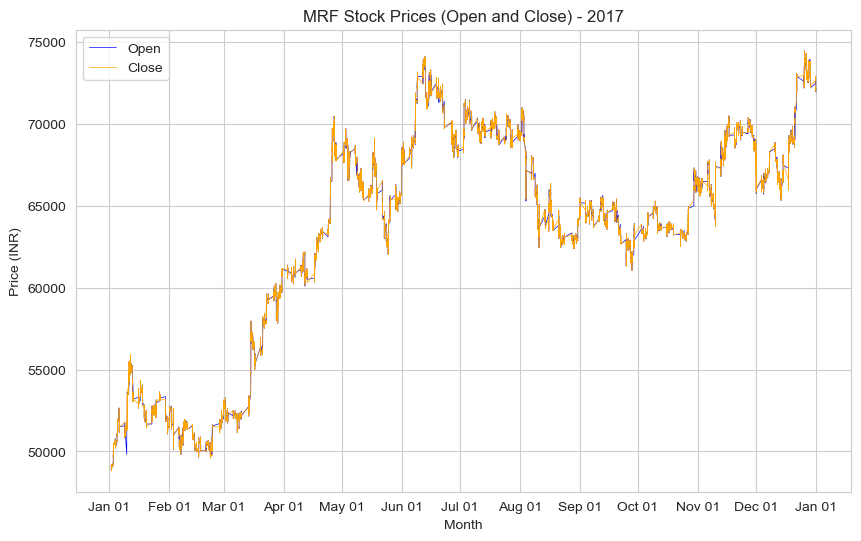

In [19]:
import matplotlib.dates as mdates
# Extracting data for plot
dates = mdates.date2num(MRF_yearly_stock.select('timestamp').toPandas()['timestamp'])
open_prices = MRF_yearly_stock.select('open').toPandas()['open']
close_prices = MRF_yearly_stock.select('close').toPandas()['close']
# Plotting line graph with reduced line thickness
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dates, open_prices, label='Open', linestyle='-', color='blue', linewidth=0.5)
ax.plot(dates, close_prices, label='Close', linestyle='-', color='orange', linewidth=0.5)
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_title('MRF Stock Prices (Open and Close) - 2017')
ax.set_xlabel('Month')
ax.set_ylabel('Price (INR)')
plt.legend()
plt.show()

# EDA 2:Plot of MRF Stock Prices volume - 2017

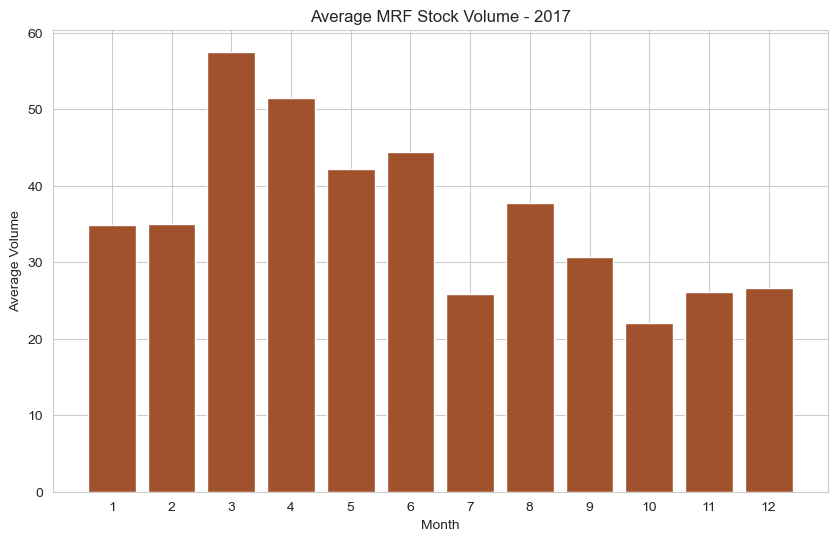

In [20]:
from pyspark.sql import functions as F

# Convert 'timestamp' column to date type
MRF_yearly_stock = MRF_yearly_stock.withColumn('timestamp', F.to_date('timestamp'))

# Extract month and year information
MRF_yearly_stock = MRF_yearly_stock.withColumn('month', F.month('timestamp'))

# Calculate average volume for each month
monthly_avg_volume = (
    MRF_yearly_stock.groupBy('month')
    .agg(F.avg('volume').alias('avg_volume'))
    .sort('month')
)

# Collect data to the driver for plotting (if data size allows)
avg_volume_pd = monthly_avg_volume.toPandas()

# Plotting bar graph for average volume per month
plt.figure(figsize=(10, 6))
plt.bar(avg_volume_pd['month'], avg_volume_pd['avg_volume'], color='sienna')
plt.title('Average MRF Stock Volume - 2017')
plt.xlabel('Month')
plt.ylabel('Average Volume')
plt.xticks(avg_volume_pd['month'])
plt.show()


In [21]:
# Filter data for pageindia company and the year 2017
PAGEIND_yearly_stock = final_df.filter((final_df['file_name'] == 'PAGEIND') & (final_df['year'] == 2017))
# Show the resulting DataFrame
PAGEIND_yearly_stock.show()

+-------------------+--------+--------+--------+--------+------+---------+---+-----+----+----+------+
|          timestamp|    open|    high|     low|   close|volume|file_name|day|month|year|hour|minute|
+-------------------+--------+--------+--------+--------+------+---------+---+-----+----+----+------+
|2017-01-01 22:45:00| 13787.3| 13787.3|13521.05|13637.85| 107.0|  PAGEIND|  1|    1|2017|  22|    45|
|2017-01-01 22:46:00| 13641.0| 13674.3|13615.05| 13630.7|  40.0|  PAGEIND|  1|    1|2017|  22|    46|
|2017-01-01 22:47:00|13551.05|13614.45|13551.05| 13581.0| 175.0|  PAGEIND|  1|    1|2017|  22|    47|
|2017-01-01 22:48:00| 13580.0| 13595.0| 13580.0| 13595.0|  60.0|  PAGEIND|  1|    1|2017|  22|    48|
|2017-01-01 22:49:00| 13572.4|13584.35| 13570.0| 13580.0|  18.0|  PAGEIND|  1|    1|2017|  22|    49|
|2017-01-01 22:50:00| 13580.0| 13580.0|13549.85|13549.85|  19.0|  PAGEIND|  1|    1|2017|  22|    50|
|2017-01-01 22:51:00|13549.85|13549.85|13532.05| 13549.8|   4.0|  PAGEIND|  1|    

# EDA 3:Plot of PAGE_IND stock prices (Open and Close) - 2017

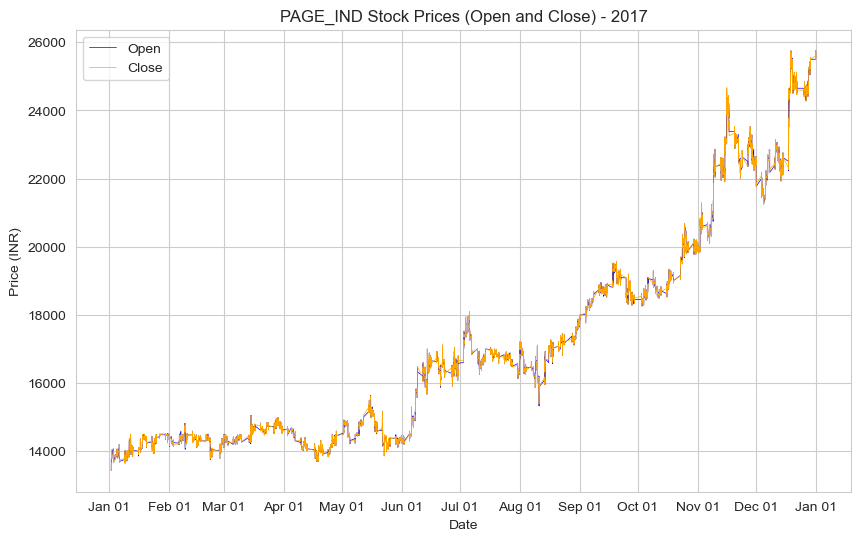

In [22]:
# Extracting data for plot
dates = mdates.date2num(PAGEIND_yearly_stock.select('timestamp').toPandas()['timestamp'])
open_prices = PAGEIND_yearly_stock.select('open').toPandas()['open']
close_prices = PAGEIND_yearly_stock.select('close').toPandas()['close']
# Plotting line graph with reduced line thickness
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dates, open_prices, label='Open', linestyle='-', color='blue', linewidth=0.5)
ax.plot(dates, close_prices, label='Close', linestyle='-', color='orange', linewidth=0.5)
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_title('PAGE_IND Stock Prices (Open and Close) - 2017')
ax.set_xlabel('Date')
ax.set_ylabel('Price (INR)')
plt.legend()
plt.show()

# EDA 4:Plot of PAGE_IND Stock Prices volume - 2017

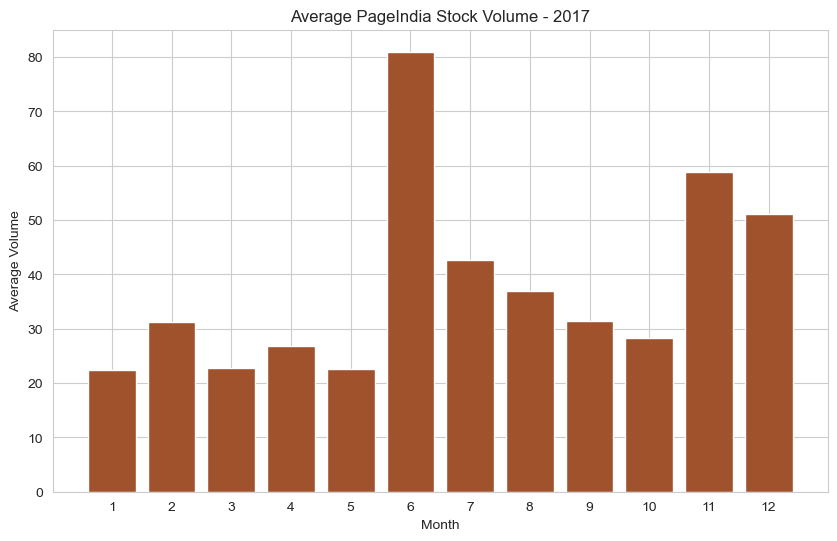

In [23]:
from pyspark.sql import functions as F

# Convert 'timestamp' column to date type
PAGEIND_yearly_stock = PAGEIND_yearly_stock.withColumn('timestamp', F.to_date('timestamp'))

# Extract month and year information
PAGEIND_yearly_stock = PAGEIND_yearly_stock.withColumn('month', F.month('timestamp'))

# Calculate average volume for each month
monthly_avg_volume = (
    PAGEIND_yearly_stock.groupBy('month')
    .agg(F.avg('volume').alias('avg_volume'))
    .sort('month')
)

# Collect data to the driver for plotting (if data size allows)
avg_volume_pd = monthly_avg_volume.toPandas()

# Plotting bar graph for average volume per month
plt.figure(figsize=(10, 6))
plt.bar(avg_volume_pd['month'], avg_volume_pd['avg_volume'], color='sienna')
plt.title('Average PageIndia Stock Volume - 2017')
plt.xlabel('Month')
plt.ylabel('Average Volume')
plt.xticks(avg_volume_pd['month'])
plt.show()


In [24]:
# Filtering data for MRF company and the year 2017
SHREECEM_yearly_stock = final_df.filter((final_df['file_name'] == 'SHREECEM') & (final_df['year'] == 2017))
# Show the resulting DataFrame
SHREECEM_yearly_stock.show()

+-------------------+--------+--------+--------+--------+------+---------+---+-----+----+----+------+
|          timestamp|    open|    high|     low|   close|volume|file_name|day|month|year|hour|minute|
+-------------------+--------+--------+--------+--------+------+---------+---+-----+----+----+------+
|2017-01-01 22:45:00|14748.45| 14875.1| 14616.0|14740.15| 125.0| SHREECEM|  1|    1|2017|  22|    45|
|2017-01-01 22:46:00|14740.15| 14868.0| 14697.8| 14702.0|  96.0| SHREECEM|  1|    1|2017|  22|    46|
|2017-01-01 22:47:00| 14685.2| 14750.0| 14685.2| 14717.3|  13.0| SHREECEM|  1|    1|2017|  22|    47|
|2017-01-01 22:48:00| 14717.3| 14740.0| 14715.0| 14740.0|  31.0| SHREECEM|  1|    1|2017|  22|    48|
|2017-01-01 22:49:00| 14740.0| 14845.0| 14740.0| 14790.0|  86.0| SHREECEM|  1|    1|2017|  22|    49|
|2017-01-01 22:50:00| 14790.0|14867.95|14764.25|14764.25|  86.0| SHREECEM|  1|    1|2017|  22|    50|
|2017-01-01 22:51:00| 14764.1|14794.95| 14764.1|14794.95|  21.0| SHREECEM|  1|    

# EDA 5:Plot of Shreecem stock prices (Open and Close) - 2017

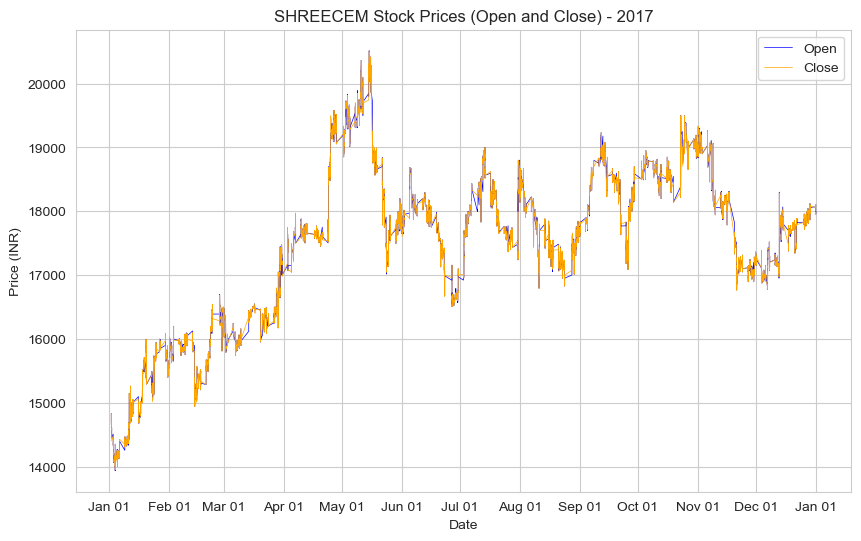

In [25]:
# Extracting data for plot
dates = mdates.date2num(SHREECEM_yearly_stock.select('timestamp').toPandas()['timestamp'])
open_prices = SHREECEM_yearly_stock.select('open').toPandas()['open']
close_prices = SHREECEM_yearly_stock.select('close').toPandas()['close']
# Plotting line graph with reduced line thickness
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dates, open_prices, label='Open', linestyle='-', color='blue', linewidth=0.5)
ax.plot(dates, close_prices, label='Close', linestyle='-', color='orange', linewidth=0.5)
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_title('SHREECEM Stock Prices (Open and Close) - 2017')
ax.set_xlabel('Date')
ax.set_ylabel('Price (INR)')
plt.legend()
plt.show()

In [26]:
# Filter data for MRF company and the year 2017
NESTLEIND_yearly_stock = final_df.filter((final_df['file_name'] == 'NESTLEIND') & (final_df['year'] == 2017))
# Show the resulting DataFrame
NESTLEIND_yearly_stock.show()

+-------------------+-------+-------+-------+-------+------+---------+---+-----+----+----+------+
|          timestamp|   open|   high|    low|  close|volume|file_name|day|month|year|hour|minute|
+-------------------+-------+-------+-------+-------+------+---------+---+-----+----+----+------+
|2017-01-01 22:45:00| 6030.0|6039.05| 6030.0|6039.05|   5.0|NESTLEIND|  1|    1|2017|  22|    45|
|2017-01-01 22:46:00| 6040.0|6081.05| 6040.0| 6070.0|  59.0|NESTLEIND|  1|    1|2017|  22|    46|
|2017-01-01 22:47:00| 6070.0| 6080.0| 6070.0| 6079.6|  61.0|NESTLEIND|  1|    1|2017|  22|    47|
|2017-01-01 22:48:00| 6079.6| 6079.6|6049.15|6049.15|  37.0|NESTLEIND|  1|    1|2017|  22|    48|
|2017-01-01 22:49:00|6049.15|6067.25|6049.15|6062.15|  16.0|NESTLEIND|  1|    1|2017|  22|    49|
|2017-01-01 22:50:00|6062.15|6062.15| 6048.0| 6048.0| 158.0|NESTLEIND|  1|    1|2017|  22|    50|
|2017-01-01 22:51:00| 6048.0| 6048.0|6001.35| 6031.9| 220.0|NESTLEIND|  1|    1|2017|  22|    51|
|2017-01-01 22:52:00

In [27]:
# EDA 4:Plot of SHREECEM Stock Prices volume - 2017

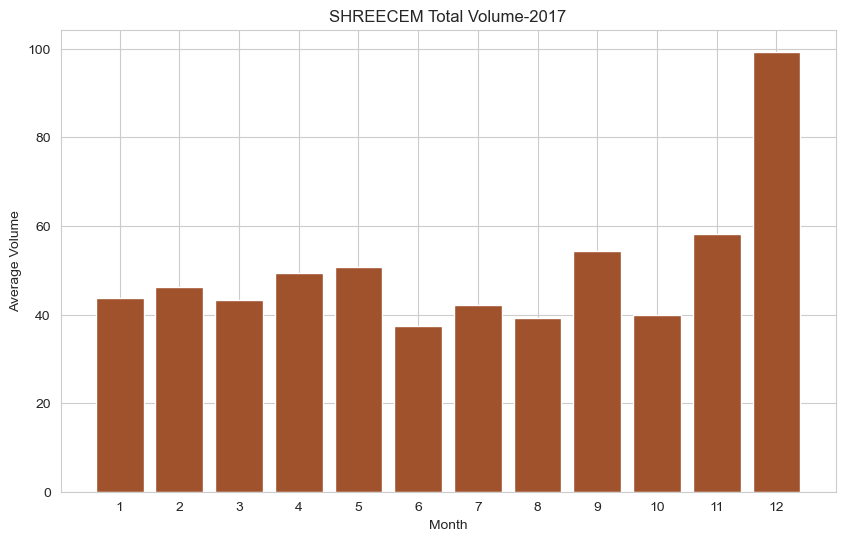

In [28]:
from pyspark.sql import functions as F

# Convert 'timestamp' column to date type
SHREECEM_yearly_stock = SHREECEM_yearly_stock.withColumn('timestamp', F.to_date('timestamp'))

# Extract month and year information
SHREECEM_yearly_stock = SHREECEM_yearly_stock.withColumn('month', F.month('timestamp'))

# Calculate average volume for each month
monthly_avg_volume = (
    SHREECEM_yearly_stock .groupBy('month')
    .agg(F.avg('volume').alias('avg_volume'))
    .sort('month')
)

# Collect data to the driver for plotting (if data size allows)
avg_volume_pd = monthly_avg_volume.toPandas()

# Plotting bar graph for average volume per month
plt.figure(figsize=(10, 6))
plt.bar(avg_volume_pd['month'], avg_volume_pd['avg_volume'], color='sienna')
plt.title('SHREECEM Total Volume-2017')
plt.xlabel('Month')
plt.ylabel('Average Volume')
plt.xticks(avg_volume_pd['month'])
plt.show()

# EDA 6:Plot of NESTLEIND Stock Prices(Open and Close)2017

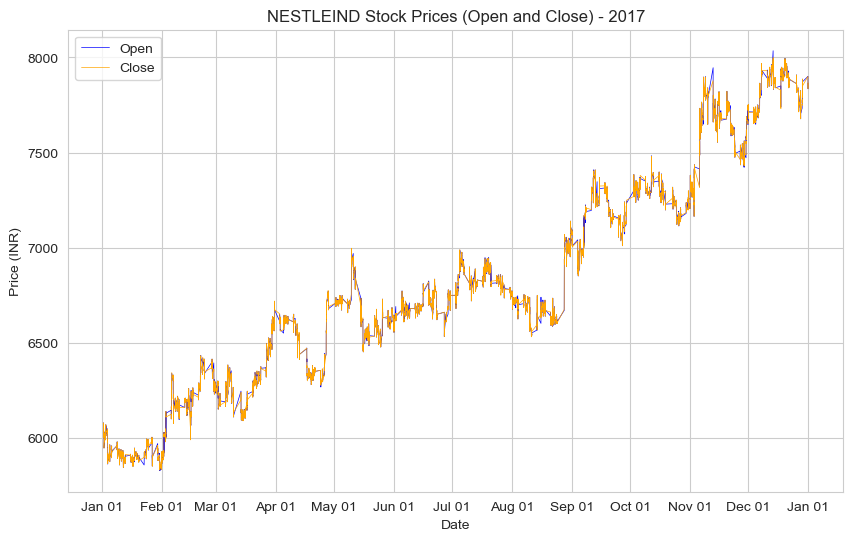

In [29]:
# Extract data for plot
dates = mdates.date2num(NESTLEIND_yearly_stock.select('timestamp').toPandas()['timestamp'])
open_prices = NESTLEIND_yearly_stock.select('open').toPandas()['open']
close_prices = NESTLEIND_yearly_stock.select('close').toPandas()['close']

# Plotting line graph with reduced line thickness
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dates, open_prices, label='Open', linestyle='-', color='blue', linewidth=0.5)
ax.plot(dates, close_prices, label='Close', linestyle='-', color='orange', linewidth=0.5)

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax.set_title('NESTLEIND Stock Prices (Open and Close) - 2017')
ax.set_xlabel('Date')
ax.set_ylabel('Price (INR)')
plt.legend()
plt.show()

# EDA 7:Plot of Nestleind Total Volume - 2017

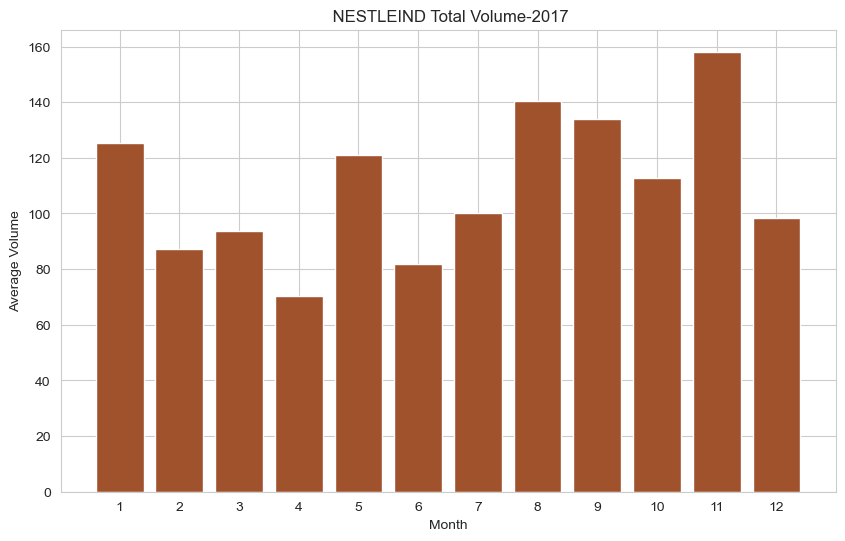

In [30]:
from pyspark.sql import functions as F

# Convert 'timestamp' column to date type
NESTLEIND_yearly_stock = NESTLEIND_yearly_stock.withColumn('timestamp', F.to_date('timestamp'))

# Extract month and year information
NESTLEIND_yearly_stock = NESTLEIND_yearly_stock.withColumn('month', F.month('timestamp'))

# Calculate average volume for each month
monthly_avg_volume = (
    NESTLEIND_yearly_stock .groupBy('month')
    .agg(F.avg('volume').alias('avg_volume'))
    .sort('month')
)

# Collect data to the driver for plotting (if data size allows)
avg_volume_pd = monthly_avg_volume.toPandas()

# Plotting bar graph for average volume per month
plt.figure(figsize=(10, 6))
plt.bar(avg_volume_pd['month'], avg_volume_pd['avg_volume'], color='sienna')
plt.title(' NESTLEIND Total Volume-2017')
plt.xlabel('Month')
plt.ylabel('Average Volume')
plt.xticks(avg_volume_pd['month'])
plt.show()

In [31]:
# Filter data for MRF company and the year 2017
MARUTI_yearly_stock = final_df.filter((final_df['file_name'] == 'MARUTI') & (final_df['year'] == 2017))
# Show the resulting DataFrame
MARUTI_yearly_stock.show()

+-------------------+-------+-------+-------+-------+-------+---------+---+-----+----+----+------+
|          timestamp|   open|   high|    low|  close| volume|file_name|day|month|year|hour|minute|
+-------------------+-------+-------+-------+-------+-------+---------+---+-----+----+----+------+
|2017-01-01 22:45:00|5336.25| 5349.7| 5321.2|5342.45| 9385.0|   MARUTI|  1|    1|2017|  22|    45|
|2017-01-01 22:46:00| 5342.9| 5343.6| 5325.1| 5330.6| 3666.0|   MARUTI|  1|    1|2017|  22|    46|
|2017-01-01 22:47:00| 5331.9| 5333.8| 5310.0|5313.45| 4651.0|   MARUTI|  1|    1|2017|  22|    47|
|2017-01-01 22:48:00|5311.05| 5313.9|5302.85| 5304.0| 5654.0|   MARUTI|  1|    1|2017|  22|    48|
|2017-01-01 22:49:00| 5305.7| 5307.5| 5271.2| 5271.2|13687.0|   MARUTI|  1|    1|2017|  22|    49|
|2017-01-01 22:50:00| 5271.0|5282.55|5270.45| 5276.3| 7818.0|   MARUTI|  1|    1|2017|  22|    50|
|2017-01-01 22:51:00| 5276.3| 5284.5| 5275.0| 5278.5| 4892.0|   MARUTI|  1|    1|2017|  22|    51|
|2017-01-0

# RISK ANALAYSIS

23/12/10 23:08:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


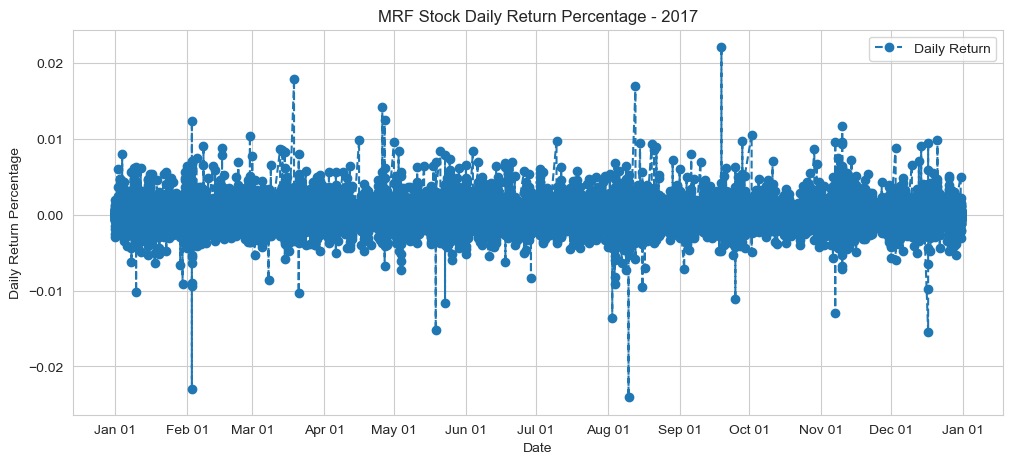

23/12/10 23:08:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


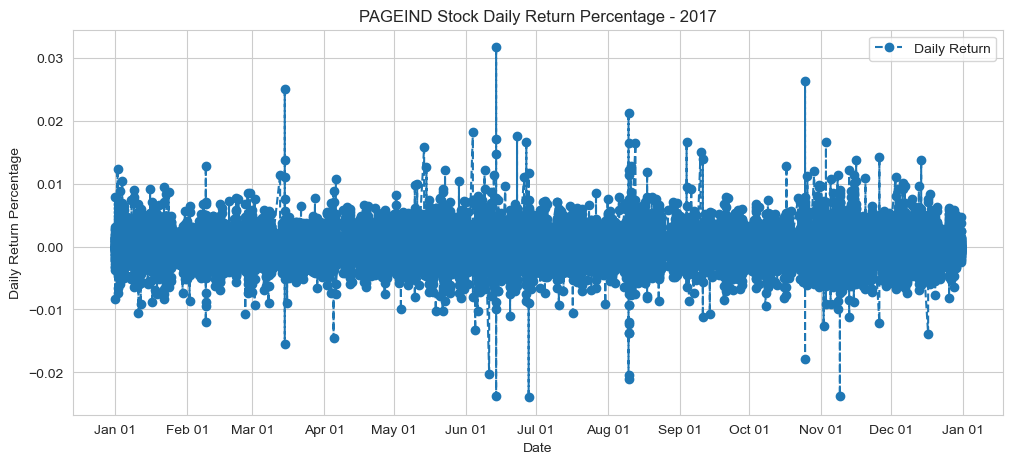

23/12/10 23:08:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


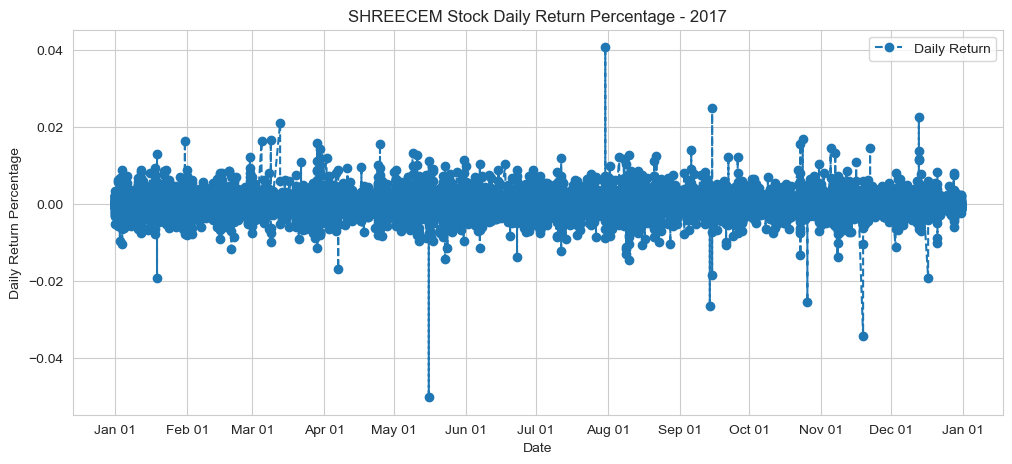

23/12/10 23:08:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


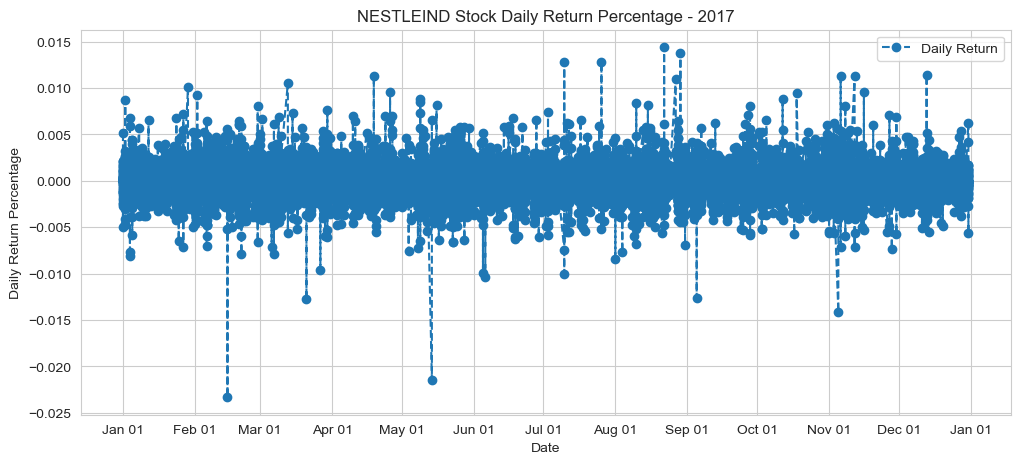

23/12/10 23:08:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


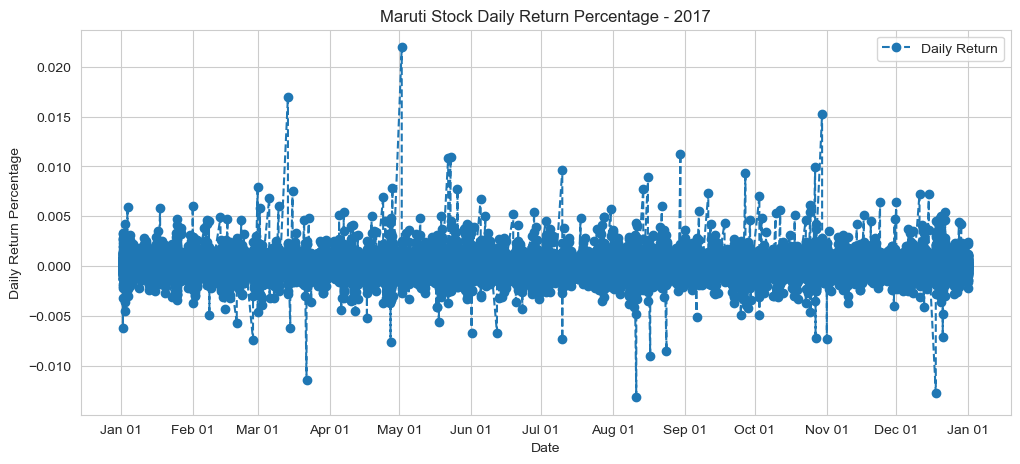

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import col, lag
import matplotlib.pyplot as plt


# Calculate the percentage change for each day
window_spec = Window.orderBy("Timestamp")
MRF_yearly_stock = MRF_yearly_stock.withColumn('Daily Return', (col('Close') - lag('Close').over(window_spec)) / lag('Close').over(window_spec))

# Extract data for plot
dates = mdates.date2num(MRF_yearly_stock.select('Timestamp').toPandas()['Timestamp'])
daily_return = MRF_yearly_stock.select('Daily Return').toPandas()['Daily Return']

# Plotting the daily return percentage
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates, daily_return, label='Daily Return', linestyle='--', marker='o')

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax.set_title('MRF Stock Daily Return Percentage - 2017')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return Percentage')
plt.legend()
plt.show()

window_spec = Window.orderBy("Timestamp")
PAGEIND_yearly_stock = PAGEIND_yearly_stock.withColumn('Daily Return', (col('Close') - lag('Close').over(window_spec)) / lag('Close').over(window_spec))

# Extract data for plot
dates = mdates.date2num(PAGEIND_yearly_stock.select('Timestamp').toPandas()['Timestamp'])
daily_return = PAGEIND_yearly_stock.select('Daily Return').toPandas()['Daily Return']

# Plotting the daily return percentage
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates, daily_return, label='Daily Return', linestyle='--', marker='o')

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax.set_title('PAGEIND Stock Daily Return Percentage - 2017')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return Percentage')
plt.legend()
plt.show()

window_spec = Window.orderBy("Timestamp")
SHREECEM_yearly_stock = SHREECEM_yearly_stock.withColumn('Daily Return', (col('Close') - lag('Close').over(window_spec)) / lag('Close').over(window_spec))

# Extract data for plot
dates = mdates.date2num(SHREECEM_yearly_stock.select('Timestamp').toPandas()['Timestamp'])
daily_return = SHREECEM_yearly_stock.select('Daily Return').toPandas()['Daily Return']

# Plotting the daily return percentage
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates, daily_return, label='Daily Return', linestyle='--', marker='o')

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax.set_title('SHREECEM Stock Daily Return Percentage - 2017')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return Percentage')
plt.legend()
plt.show()


window_spec = Window.orderBy("Timestamp")
NESTLEIND_yearly_stock = NESTLEIND_yearly_stock.withColumn('Daily Return', (col('Close') - lag('Close').over(window_spec)) / lag('Close').over(window_spec))

# Extract data for plot
dates = mdates.date2num(NESTLEIND_yearly_stock.select('Timestamp').toPandas()['Timestamp'])
daily_return = NESTLEIND_yearly_stock.select('Daily Return').toPandas()['Daily Return']

# Plotting the daily return percentage
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates, daily_return, label='Daily Return', linestyle='--', marker='o')

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax.set_title('NESTLEIND Stock Daily Return Percentage - 2017')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return Percentage')
plt.legend()
plt.show()


window_spec = Window.orderBy("Timestamp")
MARUTI_yearly_stock = MARUTI_yearly_stock.withColumn('Daily Return', (col('Close') - lag('Close').over(window_spec)) / lag('Close').over(window_spec))

# Extract data for plot
dates = mdates.date2num(MARUTI_yearly_stock.select('Timestamp').toPandas()['Timestamp'])
daily_return = MARUTI_yearly_stock.select('Daily Return').toPandas()['Daily Return']

# Plotting the daily return percentage
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates, daily_return, label='Daily Return', linestyle='--', marker='o')

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax.set_title('Maruti Stock Daily Return Percentage - 2017')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return Percentage')
plt.legend()
plt.show()


In [33]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
risk_analysis = MRF_yearly_stock.agg(
    F.stddev('Daily Return').alias('StandardDeviation'),
    F.avg('Daily Return').alias('Mean')
).collect()

std_deviation = risk_analysis[0]['StandardDeviation']
mean_value = risk_analysis[0]['Mean']

print("Standard Deviation of Daily Returns:", std_deviation)
print("Mean of Daily Returns:", mean_value)

alpha = 0.95
z_score = 1.645  # For a normal distribution, you can use a z-score of 1.645 for 95% confidence

var = mean_value - z_score * std_deviation
print(f"Value at Risk (VaR) at {alpha} confidence level:", var)

# Assuming risk-free rate is 0 for simplicity
risk_free_rate = 0.0
sharpe_ratio = (mean_value - risk_free_rate) / std_deviation
print("Sharpe Ratio:", sharpe_ratio)




23/12/10 23:08:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Standard Deviation of Daily Returns: 0.0008534275541133555
Mean of Daily Returns: 4.521706597464613e-06
Value at Risk (VaR) at 0.95 confidence level: -0.0013993666199190052
Sharpe Ratio: 0.005298289908347654


23/12/10 23:08:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [34]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
risk_analysis = PAGEIND_yearly_stock.agg(
    F.stddev('Daily Return').alias('StandardDeviation'),
    F.avg('Daily Return').alias('Mean')
).collect()

std_deviation = risk_analysis[0]['StandardDeviation']
mean_value = risk_analysis[0]['Mean']

print("Standard Deviation of Daily Returns:", std_deviation)
print("Mean of Daily Returns:", mean_value)

alpha = 0.95
z_score = 1.645  # For a normal distribution, you can use a z-score of 1.645 for 95% confidence

var = mean_value - z_score * std_deviation
print(f"Value at Risk (VaR) at {alpha} confidence level:", var)

# Assuming risk-free rate is 0 for simplicity
risk_free_rate = 0.0
sharpe_ratio = (mean_value - risk_free_rate) / std_deviation
print("Sharpe Ratio:", sharpe_ratio)

23/12/10 23:08:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:08:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Standard Deviation of Daily Returns: 0.0012986478780070412
Mean of Daily Returns: 7.6142741574329485e-06
Value at Risk (VaR) at 0.95 confidence level: -0.0021286614851641497
Sharpe Ratio: 0.005863232279036353


23/12/10 23:09:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:09:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [35]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
risk_analysis = NESTLEIND_yearly_stock.agg(
    F.stddev('Daily Return').alias('StandardDeviation'),
    F.avg('Daily Return').alias('Mean')
).collect()

std_deviation = risk_analysis[0]['StandardDeviation']
mean_value = risk_analysis[0]['Mean']

print("Standard Deviation of Daily Returns:", std_deviation)
print("Mean of Daily Returns:", mean_value)


alpha = 0.95
z_score = 1.645  # For a normal distribution, you can use a z-score of 1.645 for 95% confidence

var = mean_value - z_score * std_deviation
print(f"Value at Risk (VaR) at {alpha} confidence level:", var)

# Assuming risk-free rate is 0 for simplicity
risk_free_rate = 0.0
sharpe_ratio = (mean_value - risk_free_rate) / std_deviation
print("Sharpe Ratio:", sharpe_ratio)


23/12/10 23:09:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:09:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Standard Deviation of Daily Returns: 0.0007924727130269917
Mean of Daily Returns: 3.1683324465042755e-06
Value at Risk (VaR) at 0.95 confidence level: -0.001300449280482897
Sharpe Ratio: 0.0039980334898879494


23/12/10 23:09:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:09:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [36]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
risk_analysis = SHREECEM_yearly_stock.agg(
    F.stddev('Daily Return').alias('StandardDeviation'),
    F.avg('Daily Return').alias('Mean')
).collect()

std_deviation = risk_analysis[0]['StandardDeviation']
mean_value = risk_analysis[0]['Mean']

print("Standard Deviation of Daily Returns:", std_deviation)
print("Mean of Daily Returns:", mean_value)

alpha = 0.95
z_score = 1.645  # For a normal distribution, you can use a z-score of 1.645 for 95% confidence

var = mean_value - z_score * std_deviation
print(f"Value at Risk (VaR) at {alpha} confidence level:", var)

# Assuming risk-free rate is 0 for simplicity
risk_free_rate = 0.0
sharpe_ratio = (mean_value - risk_free_rate) / std_deviation
print("Sharpe Ratio:", sharpe_ratio)


23/12/10 23:09:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:09:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Standard Deviation of Daily Returns: 0.0011567872462700073
Mean of Daily Returns: 2.8174764044668444e-06
Value at Risk (VaR) at 0.95 confidence level: -0.001900097543709695
Sharpe Ratio: 0.0024356046572536413


23/12/10 23:09:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:09:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [37]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
risk_analysis = MARUTI_yearly_stock.agg(
    F.stddev('Daily Return').alias('StandardDeviation'),
    F.avg('Daily Return').alias('Mean')
).collect()

std_deviation = risk_analysis[0]['StandardDeviation']
mean_value = risk_analysis[0]['Mean']

print("Standard Deviation of Daily Returns:", std_deviation)
print("Mean of Daily Returns:", mean_value)

alpha = 0.95
z_score = 1.645  # For a normal distribution, you can use a z-score of 1.645 for 95% confidence

var = mean_value - z_score * std_deviation
print(f"Value at Risk (VaR) at {alpha} confidence level:", var)

# Assuming risk-free rate is 0 for simplicity
risk_free_rate = 0.0
sharpe_ratio = (mean_value - risk_free_rate) / std_deviation
print("Sharpe Ratio:", sharpe_ratio)



23/12/10 23:09:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:09:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Standard Deviation of Daily Returns: 0.0005622933624733589
Mean of Daily Returns: 6.671283213539836e-06
Value at Risk (VaR) at 0.95 confidence level: -0.0009183012980551355
Sharpe Ratio: 0.011864417506539422


23/12/10 23:09:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 23:09:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


# Checking closing stocks during (2018-March) and during 2019 (Covid peak time-March)

For the top 5 stocks 

1)MRF_close

2)PAGEIND_close

3)SHREECEM_close

4)NESTLEIND_close

5)MARUTI_close

In [38]:

# Filter data for MRF company and the year 2017
MRF_yearly_stock_2018 = final_df.filter((final_df['file_name'] == 'MRF') & (final_df['year'] == 2018))
# Filter data for MRF company and the year 2018
PAGEIND_yearly_stock_2018 = final_df.filter((final_df['file_name'] == 'PAGEIND') & (final_df['year'] == 2018))
SHREECEM_yearly_stock_2018 = final_df.filter((final_df['file_name'] == 'SHREECEM') & (final_df['year'] == 2018))
NESTLEIND_yearly_stock_2018 = final_df.filter((final_df['file_name'] == 'NESTLEIND') & (final_df['year'] == 2018))
MARUTI_yearly_stock_2018 = final_df.filter((final_df['file_name'] == 'MARUTI') & (final_df['year'] == 2018))

# Filter data for MRF company and the year 2017
MRF_yearly_stock_2019 = final_df.filter((final_df['file_name'] == 'MRF') & (final_df['year'] == 2019))
# Filter data for MRF company and the year 2018
PAGEIND_yearly_stock_2019 = final_df.filter((final_df['file_name'] == 'PAGEIND') & (final_df['year'] == 2019))
SHREECEM_yearly_stock_2019 = final_df.filter((final_df['file_name'] == 'SHREECEM') & (final_df['year'] == 2019))
NESTLEIND_yearly_stock_2019 = final_df.filter((final_df['file_name'] == 'NESTLEIND') & (final_df['year'] == 2019))
MARUTI_yearly_stock_2019 = final_df.filter((final_df['file_name'] == 'MARUTI') & (final_df['year'] == 2019))



# Show the resulting DataFrame
MRF_yearly_stock_2018.show()

# Show the resulting DataFrame
MRF_yearly_stock_2019.show()

+-------------------+--------+--------+--------+--------+------+---------+---+-----+----+----+------+
|          timestamp|    open|    high|     low|   close|volume|file_name|day|month|year|hour|minute|
+-------------------+--------+--------+--------+--------+------+---------+---+-----+----+----+------+
|2018-01-01 00:00:00|72224.95|72224.95|72224.95|72224.95|   0.0|      MRF|  1|    1|2018|   0|     0|
|2018-01-01 00:01:00|72224.95|72224.95|72223.95|72223.95|   5.0|      MRF|  1|    1|2018|   0|     1|
|2018-01-01 00:02:00|72223.95| 72224.7|72223.95| 72224.7|  10.0|      MRF|  1|    1|2018|   0|     2|
|2018-01-01 00:03:00| 72224.7| 72225.0|72172.55| 72225.0|   5.0|      MRF|  1|    1|2018|   0|     3|
|2018-01-01 00:04:00| 72225.0| 72225.0| 72225.0| 72225.0|   0.0|      MRF|  1|    1|2018|   0|     4|
|2018-01-01 00:05:00| 72225.0| 72248.5|72200.65| 72248.5|   6.0|      MRF|  1|    1|2018|   0|     5|
|2018-01-01 00:06:00| 72248.5| 72350.0| 72248.5|72348.55|  51.0|      MRF|  1|    

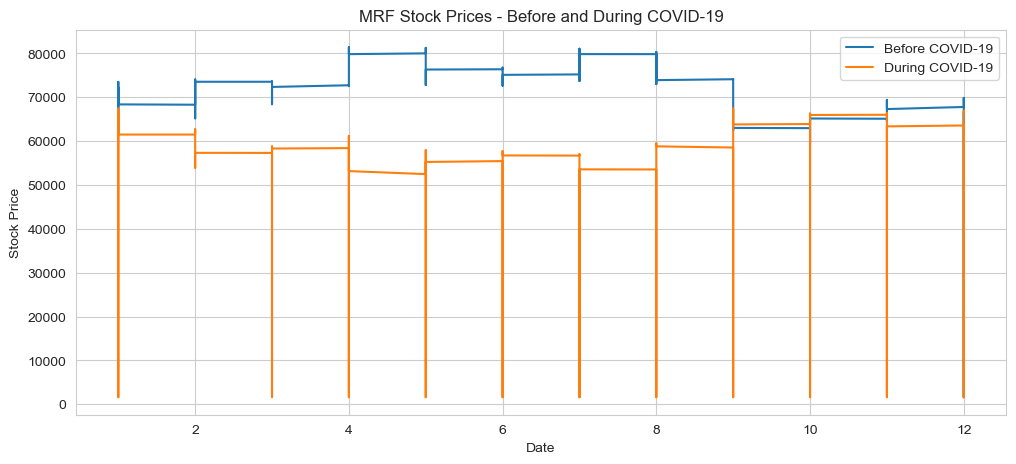

In [39]:
MRF_yearly_stock_2018 = MRF_yearly_stock_2018.orderBy('month')
MRF_yearly_stock_2019 = MRF_yearly_stock_2019.orderBy('month')

# Plotting stock prices before COVID-19 (2018)
plt.figure(figsize=(12, 5))
plt.plot(MRF_yearly_stock_2018.toPandas()['month'], MRF_yearly_stock_2018.toPandas()['close'], label='Before COVID-19')

# Plotting stock prices during COVID-19 (2019)
plt.plot(MRF_yearly_stock_2019.toPandas()['month'], MRF_yearly_stock_2019.toPandas()['close'], label='During COVID-19')

plt.title('MRF Stock Prices - Before and During COVID-19')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

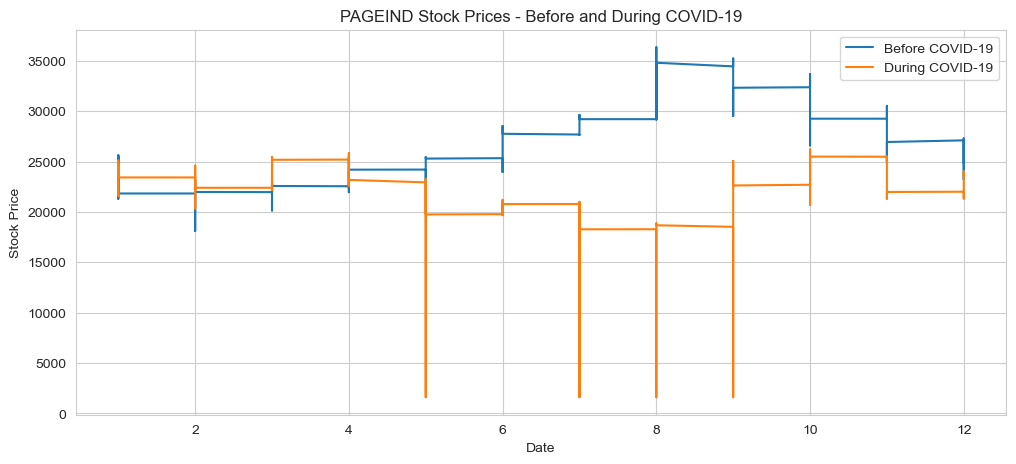

In [40]:
PAGEIND_yearly_stock_2018 = PAGEIND_yearly_stock_2018.orderBy('month')
PAGEIND_yearly_stock_2019 = PAGEIND_yearly_stock_2019.orderBy('month')

# Plotting stock prices before COVID-19 (2018)
plt.figure(figsize=(12, 5))
plt.plot(PAGEIND_yearly_stock_2018.toPandas()['month'], PAGEIND_yearly_stock_2018.toPandas()['close'], label='Before COVID-19')

# Plotting stock prices during COVID-19 (2019)
plt.plot(PAGEIND_yearly_stock_2019.toPandas()['month'], PAGEIND_yearly_stock_2019.toPandas()['close'], label='During COVID-19')

plt.title('PAGEIND Stock Prices - Before and During COVID-19')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

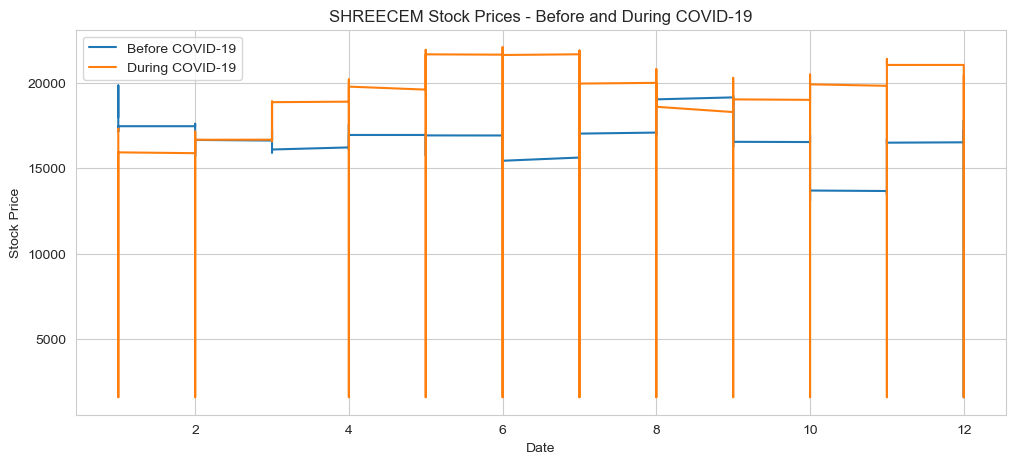

In [41]:
SHREECEM_yearly_stock_2018 = SHREECEM_yearly_stock_2018.orderBy('month')
SHREECEM_yearly_stock_2019 = SHREECEM_yearly_stock_2019.orderBy('month')

# Plotting stock prices before COVID-19 (2018)
plt.figure(figsize=(12, 5))
plt.plot(SHREECEM_yearly_stock_2018.toPandas()['month'], SHREECEM_yearly_stock_2018.toPandas()['close'], label='Before COVID-19')

# Plotting stock prices during COVID-19 (2019)
plt.plot(SHREECEM_yearly_stock_2019.toPandas()['month'], SHREECEM_yearly_stock_2019.toPandas()['close'], label='During COVID-19')

plt.title('SHREECEM Stock Prices - Before and During COVID-19')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

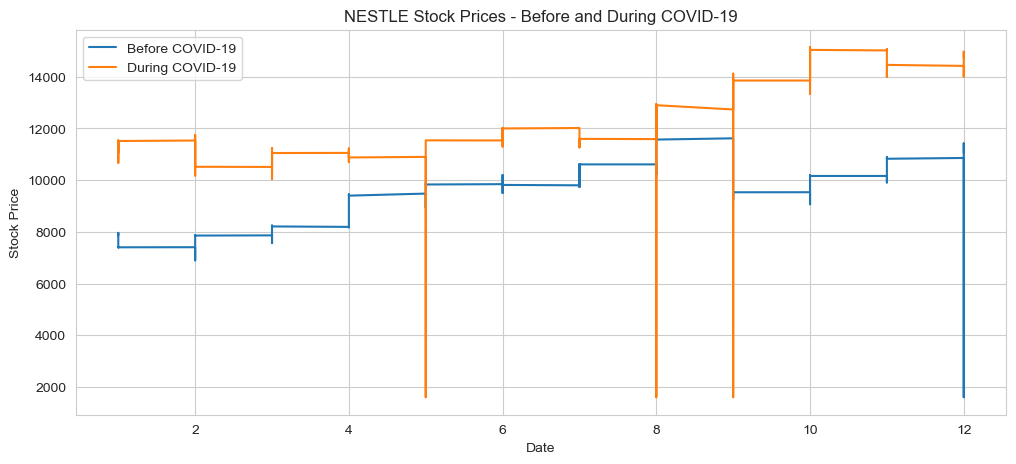

In [42]:
NESTLEIND_yearly_stock_2018 = NESTLEIND_yearly_stock_2018.orderBy('month')
NESTLEIND_yearly_stock_2019 = NESTLEIND_yearly_stock_2019.orderBy('month')

# Plotting stock prices before COVID-19 (2018)
plt.figure(figsize=(12, 5))
plt.plot(NESTLEIND_yearly_stock_2018.toPandas()['month'], NESTLEIND_yearly_stock_2018.toPandas()['close'], label='Before COVID-19')

# Plotting stock prices during COVID-19 (2019)
plt.plot(NESTLEIND_yearly_stock_2019.toPandas()['month'], NESTLEIND_yearly_stock_2019.toPandas()['close'], label='During COVID-19')

plt.title('NESTLE Stock Prices - Before and During COVID-19')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

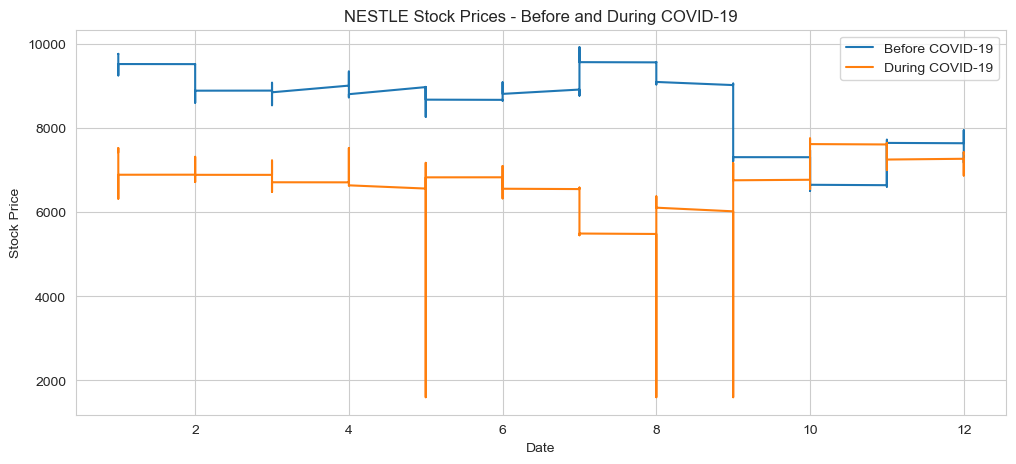

In [43]:
MARUTI_yearly_stock_2018 = MARUTI_yearly_stock_2018.orderBy('month')
MARUTI_yearly_stock_2019 = MARUTI_yearly_stock_2019.orderBy('month')

# Plotting stock prices before COVID-19 (2018)
plt.figure(figsize=(12, 5))
plt.plot(MARUTI_yearly_stock_2018.toPandas()['month'], MARUTI_yearly_stock_2018.toPandas()['close'], label='Before COVID-19')

# Plotting stock prices during COVID-19 (2019)
plt.plot(MARUTI_yearly_stock_2019.toPandas()['month'], MARUTI_yearly_stock_2019.toPandas()['close'], label='During COVID-19')

plt.title('NESTLE Stock Prices - Before and During COVID-19')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Time Series Prediction using SARIMA Model

# Time Series Prediction for PAGE INDIA

In [44]:
import pandas as pd
from pyspark.sql.functions import col, to_date, max

# Filter records for PAGEIND and convert timestamp to date
filtered_df = final_df.filter(final_df.file_name == 'PAGEIND') \
                     .withColumn('date', to_date(col('timestamp')))

# Filter records between start and end dates
filtered_df = filtered_df.filter((col('date') >= '2018-03-01') & (col('date') < '2019-04-01'))

# Group by date and select the last timestamp for each day
grouped_df = filtered_df.groupBy('date').agg(max('timestamp').alias('last_timestamp'))

# Join the original DataFrame with the grouped DataFrame to get the entire rows for the last timestamps
result_df = filtered_df.join(grouped_df, (filtered_df.date == grouped_df.date) & (filtered_df.timestamp == grouped_df.last_timestamp), 'inner') \
                      .select(final_df.columns)

# Convert PySpark DataFrame to Pandas DataFrame
time_series_data = result_df.toPandas()


In [45]:
#time_series_data = PAGEIND_pd[(PAGEIND_pd['timestamp'] >= start_date) & (PAGEIND_pd['timestamp'] <= end_date)]
time_series_data = time_series_data.set_index('timestamp')

In [46]:
# test train split
# Convert the date strings to datetime objects for comparison
time_series_data['timestamp'] = pd.to_datetime(time_series_data.index)

# Define the start and end dates for test data
test_start_date = '2019-03-01'
test_end_date = '2019-04-01'

# Filter the test data
test_data = time_series_data[(time_series_data['timestamp'] >= test_start_date) & (time_series_data['timestamp'] <= test_end_date)]

# Training data will be the rest of the data
train_data = time_series_data.drop(test_data.index)

# Optional: Reset index if needed
test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

# Optional: Set index back to 'timestamp' if required
test_data.set_index('timestamp', inplace=True)
train_data.set_index('timestamp', inplace=True)

# Verify lengths if needed
print("Train Data Length:", len(train_data))
print("Test Data Length:", len(test_data))

Train Data Length: 309
Test Data Length: 25


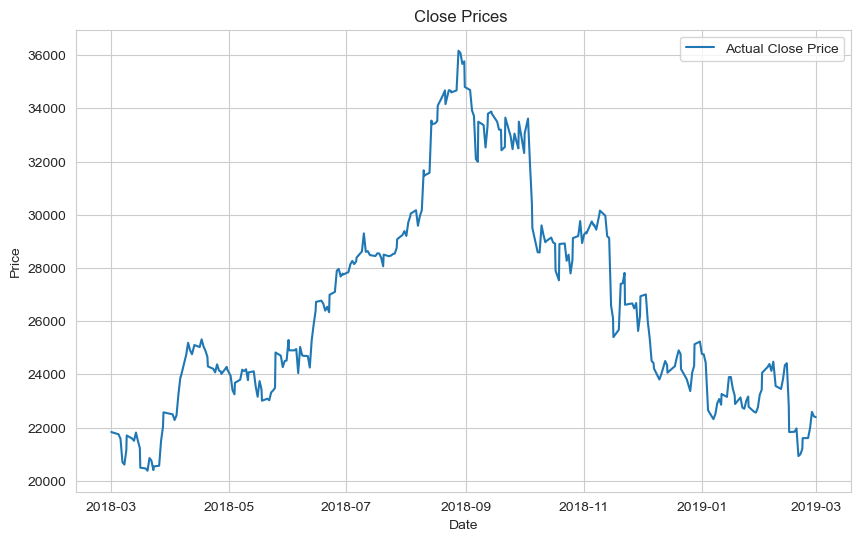

In [47]:
# Plotting the original time series data
plt.figure(figsize=(10, 6))
plt.plot( train_data['close'], label='Actual Close Price')
plt.title('Close Prices ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [48]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

def check_stationarity(differenced_series):
    # Dickey-Fuller test
    result = adfuller(differenced_series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

    # ACF plot
    plot_acf(differenced_series, lags=20)
    plt.show()

    # PACF plot
    plot_pacf(differenced_series, lags=20)
    plt.show()


ADF Statistic: -1.2786081140095946
p-value: 0.6389014244366734


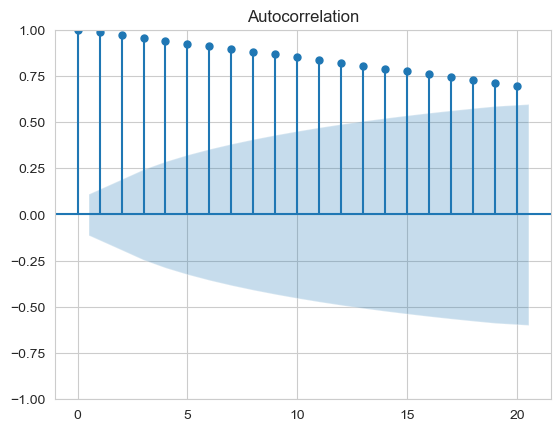

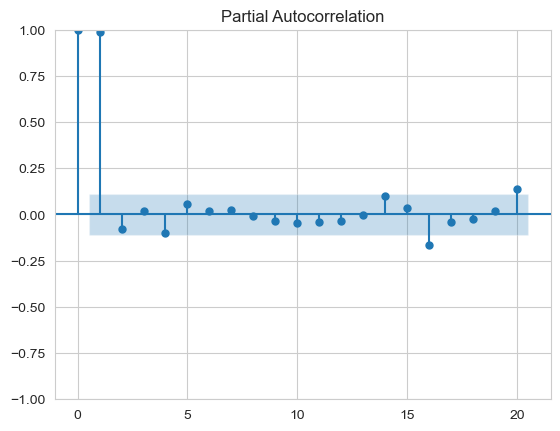

In [49]:
check_stationarity(train_data['close'])

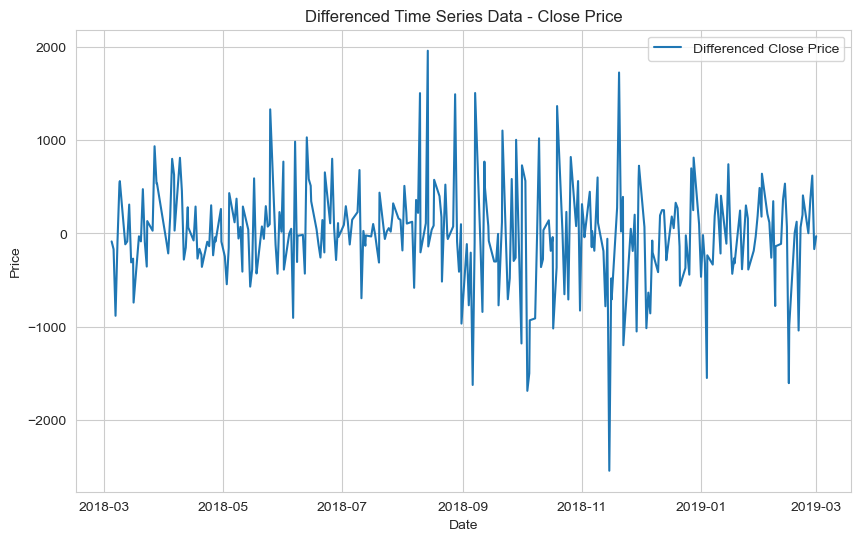

ADF Statistic (Differenced Series): -16.2060575229384
p-value (Differenced Series): 4.031166426715027e-29


In [50]:
# Differencing the series
differenced_series = train_data['close'].diff().dropna()

# Plotting the differenced series
plt.figure(figsize=(10, 6))
plt.plot(differenced_series.index, differenced_series, label='Differenced Close Price')
plt.title('Differenced Time Series Data - Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# ADF test on the differenced series
result_diff = adfuller(differenced_series)
print('ADF Statistic (Differenced Series):', result_diff[0])
print('p-value (Differenced Series):', result_diff[1])

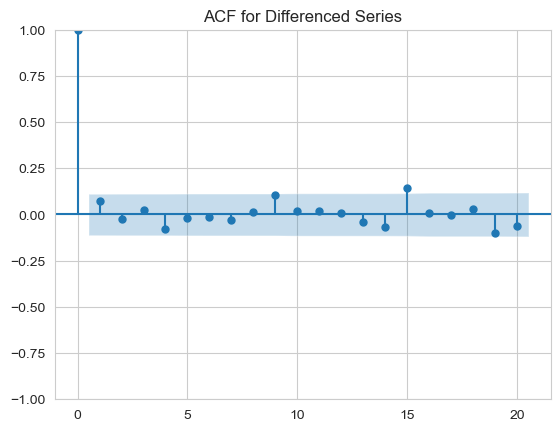

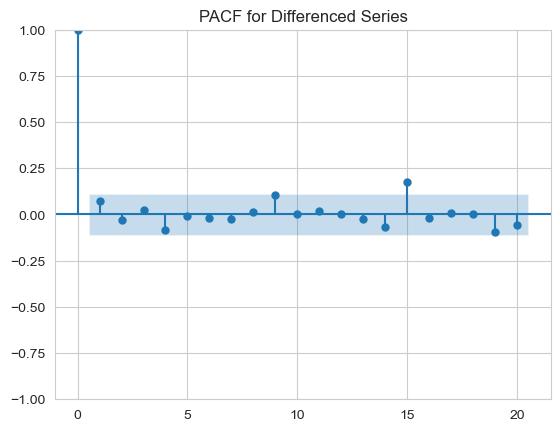

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF for differenced series
plot_acf(differenced_series, lags=20)
plt.title('ACF for Differenced Series')
plt.show()

# Plot PACF for differenced series
plot_pacf(differenced_series, lags=20)
plt.title('PACF for Differenced Series')
plt.show()

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd


order = (3, 1, 1)  # ARIMA order (p, d, q)
seasonal_order = (3, 1, 1, 12)  # Seasonal order (P, D, Q, S)

# Create and fit the SARIMA model
model = SARIMAX(train_data['close'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Forecast for the next 25 steps
forecastSarmia = model_fit.forecast(steps=25)

# Print Forecasted values
print("Forecasted values for the next 25 days:", forecastSarmia)

/Users/karthikvibuthi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karthikvibuthi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60452D+00    |proj g|=  1.48416D-01


 This problem is unconstrained.



At iterate    5    f=  7.58028D+00    |proj g|=  2.93958D-03

At iterate   10    f=  7.56877D+00    |proj g|=  6.80263D-02

At iterate   15    f=  7.56132D+00    |proj g|=  2.48342D-03

At iterate   20    f=  7.56118D+00    |proj g|=  5.06913D-03

At iterate   25    f=  7.56047D+00    |proj g|=  1.27046D-03

At iterate   30    f=  7.56043D+00    |proj g|=  3.82545D-03

At iterate   35    f=  7.55606D+00    |proj g|=  5.63477D-02

At iterate   40    f=  7.49104D+00    |proj g|=  6.44531D-02

At iterate   45    f=  7.48651D+00    |proj g|=  1.22594D-03

At iterate   50    f=  7.48638D+00    |proj g|=  2.30477D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/karthikvibuthi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasted values for the next 25 days: 309    22126.358707
310    22226.359942
311    22170.450842
312    22010.306573
313    22050.636585
314    21888.507677
315    21974.765481
316    22008.490390
317    22081.411745
318    22366.549770
319    22385.565180
320    22235.001250
321    22134.136724
322    22255.475783
323    22228.127747
324    22182.853315
325    22228.384969
326    21960.486389
327    22017.942779
328    22059.326103
329    22118.324628
330    22380.424098
331    22399.393177
332    22120.114241
333    21939.966096
Name: predicted_mean, dtype: float64


/Users/karthikvibuthi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


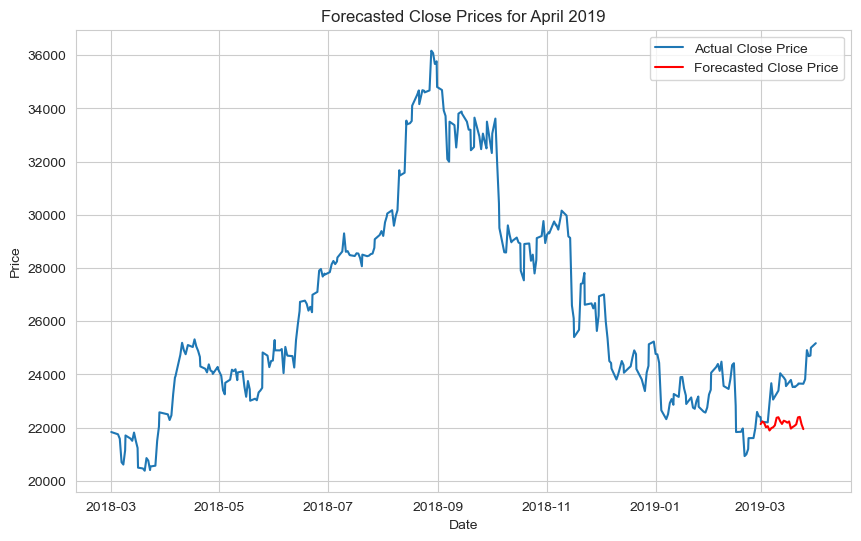

In [53]:
# Plotting the original time series data
plt.figure(figsize=(10, 6))
plt.plot( time_series_data['close'], label='Actual Close Price')

# Forecasted values index for April 2019
forecast_index = pd.date_range(start='2019-03-01', periods=len(forecastSarmia), freq='D')

# Plotting the forecasted values
plt.plot(forecast_index, forecastSarmia, color='red', label='Forecasted Close Price')

plt.title('Forecasted Close Prices for April 2019')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Time Series prediction for MRF

In [54]:
from pyspark.sql.functions import col, to_date, max

def get_last_timestamp_data(final_df, file_name):
    # Filter records for the given file_name and convert timestamp to date
    filtered_df = final_df.filter(final_df.file_name == file_name) \
                         .withColumn('date', to_date(col('timestamp')))

    # Filter records between start and end dates
    filtered_df = filtered_df.filter((col('date') >= '2018-03-01') & (col('date') < '2019-04-01'))

    # Group by date and select the last timestamp for each day
    grouped_df = filtered_df.groupBy('date').agg(max('timestamp').alias('last_timestamp'))

    # Join the original DataFrame with the grouped DataFrame to get the entire rows for the last timestamps
    result_df = filtered_df.join(grouped_df, (filtered_df.date == grouped_df.date) & (filtered_df.timestamp == grouped_df.last_timestamp), 'inner') \
                          .select(final_df.columns)

    # Convert PySpark DataFrame to Pandas DataFrame
    time_series_data = result_df.toPandas()

    return time_series_data


desired_file_name = 'MRF'
time_series_data_MRF = get_last_timestamp_data(final_df, desired_file_name)


In [56]:
import pandas as pd

def perform_test_train_split(time_series_data, test_start_date, test_end_date):
    # Convert the date strings to datetime objects for comparison
    time_series_data['timestamp'] = pd.to_datetime(time_series_data.index)

    # Filter the test data
    test_data = time_series_data[(time_series_data['timestamp'] >= test_start_date) & (time_series_data['timestamp'] <= test_end_date)]

    # Training data will be the rest of the data
    train_data = time_series_data.drop(test_data.index)

    # Reset index if needed
    test_data.reset_index(drop=True, inplace=True)
    train_data.reset_index(drop=True, inplace=True)

    # Set index back to 'timestamp' if required
    test_data.set_index('timestamp', inplace=True)
    train_data.set_index('timestamp', inplace=True)

    return train_data, test_data

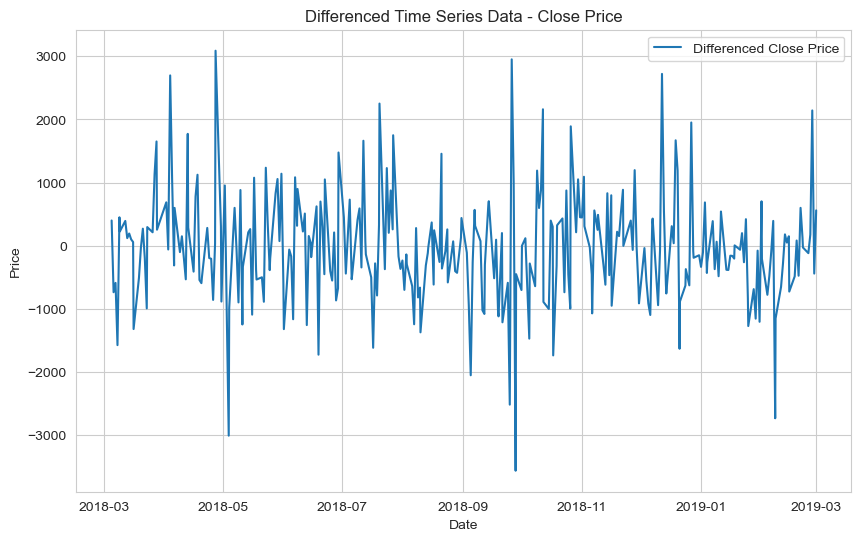

ADF Statistic (Differenced Series): -16.425468178295866
p-value (Differenced Series): 2.507117775635505e-29


In [57]:
# Differencing the series
differenced_series = train['close'].diff().dropna()

# Plotting the differenced series
plt.figure(figsize=(10, 6))
plt.plot(differenced_series.index, differenced_series, label='Differenced Close Price')
plt.title('Differenced Time Series Data - Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# ADF test on the differenced series
result_diff = adfuller(differenced_series)
print('ADF Statistic (Differenced Series):', result_diff[0])
print('p-value (Differenced Series):', result_diff[1])

ADF Statistic: -16.425468178295866
p-value: 2.507117775635505e-29


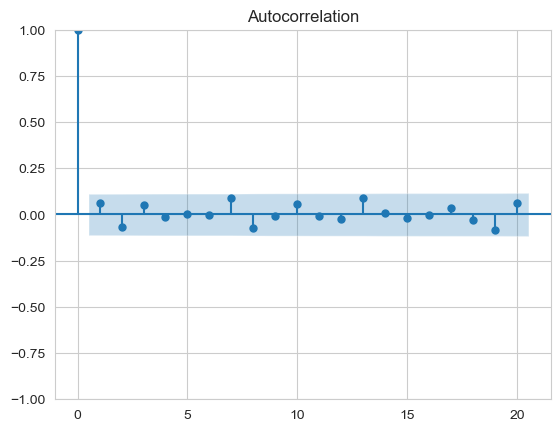

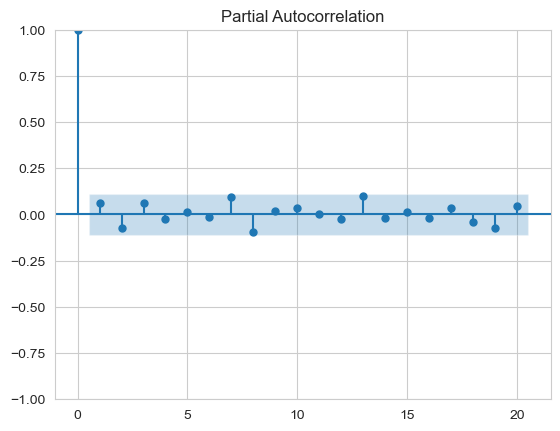

In [58]:
check_stationarity(differenced_series)

In [59]:
order = (1, 1, 1)  # ARIMA order (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Seasonal order (P, D, Q, S)

# Create and fit the SARIMA model
model = SARIMAX(train['close'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Forecast for the next 35 steps
forecastSarmia = model_fit.forecast(steps=35)

# Print Forecasted values
print("Forecasted values for the next 35 days:", forecastSarmia)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69602D+00    |proj g|=  1.95267D+00


/Users/karthikvibuthi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karthikvibuthi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  8.12661D+00    |proj g|=  4.64017D-03

At iterate   10    f=  8.12617D+00    |proj g|=  2.96019D-03

At iterate   15    f=  8.12597D+00    |proj g|=  1.39337D-02

At iterate   20    f=  8.12543D+00    |proj g|=  1.85280D-04

At iterate   25    f=  8.12542D+00    |proj g|=  1.58205D-03

At iterate   30    f=  8.12527D+00    |proj g|=  6.59194D-03

At iterate   35    f=  8.12067D+00    |proj g|=  4.80876D-02

At iterate   40    f=  8.11483D+00    |proj g|=  1.43998D-03

At iterate   45    f=  8.11482D+00    |proj g|=  1.42493D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     49   

/Users/karthikvibuthi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


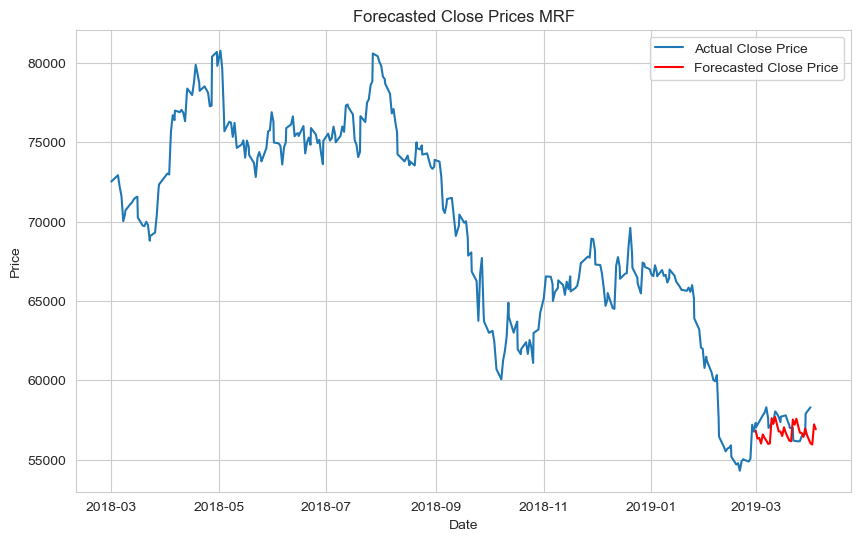

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_forecasted_data(time_series_data, forecast_values, forecast_start_date):
    plt.figure(figsize=(10, 6))
    plt.plot(time_series_data['close'], label='Actual Close Price')

    # Forecasted values index for the specified forecast start date
    forecast_index = pd.date_range(start=forecast_start_date, periods=len(forecast_values), freq='D')

    # Plotting the forecasted values
    plt.plot(forecast_index, forecast_values, color='red', label='Forecasted Close Price')

    plt.title('Forecasted Close Prices MRF')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


plot_forecasted_data(time_series_data_MRF, forecastSarmia,'2019-03-01' )
